## Introduction

Import required libraries

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

Provide the path to the file containing the data

In [2]:
path_to_csv = "data/abalone.csv"

Load the data into pandas. The data contains the following

| <p align="left">Name</p>           | <p align="left">Units</p>   | <p align="left">Description</p>      |
|:-----------------------------------|:-------:|:---------------------------------------------------------|
| <p align="left">Sex</p>            |         | <p align="left">M (male), F (female), and I (infant)</p> |
| <p align="left">Length</p>         | mm      | <p align="left">Longest shell measurement</p>            |
| <p align="left">Diameter</p>       | mm      | <p align="left">Perpendicular to length</p>              |
| <p align="left">Height</p>         | mm      | <p align="left">With meat in shell</p>                   |
| <p align="left">Whole Weight</p>   | grams   | <p align="left">Whole abalone</p>                        |
| <p align="left">Shucked weight</p> | grams   | <p align="left">Weight of meat</p>                       |
| <p align="left">Viscera weight</p> | grams   | <p align="left">Gut weight (after bleeding)</p>          |
| <p align="left">Shell weight</p>   | grams   | <p align="left">After being dried</p>                    |
| <p align="left">Rings</p>          |         | <p align="left">+1.5 gives the age in years</p>          |

In [3]:
df = pd.read_csv(path_to_csv, header=None, names = ["Sex", "Length", "Diameter", "Height", "Whole Weight", "Shucked Weight", "Viscera Weight", "Shell Weight", "Rings"])

Lets take a look at the data

In [4]:
df.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Missing Data

Lets do a search for missing data. We can do this easily with pandas using the code below.

In [5]:
nans = df[df.isnull().any(axis=1)]
nans

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
878,F,0.635,0.485,0.165,1.2945,0.6680,NaN,0.2715,9
1888,F,0.565,0.445,0.125,0.8305,0.3135,0.1785,0.2300,NaN
3093,NaN,0.520,0.430,0.150,0.7280,0.3020,0.1575,0.2350,11


As can be seen from the results of our search we have 3 NaN rows. 

- Row 878 has an invalid Viscera weight
- row 1888 has an invalid Rings value 
- row 3093 has an invalid Sex value

We can now drop the indexes that are invalid from our dataframe. Before we do that lets display the size of our data frame before and after to confirm that the 3 rows were dropped

In [6]:
df.shape

(4177, 9)

In [7]:
df.drop(df.index[[878,1888,3093]], inplace=True)

We have now dropped the indexes, lets see if the dataframe has reduced by 3

In [8]:
df.shape

(4174, 9)

We can see above that the row length has reduced from 4177 to 4174. This is a difference of exactly 3 rows.

### Erroneous Data

Lets first check for zero value numbers. It would be impossible for example to have zero length or height

In [9]:
df[(df.select_dtypes(include=['number']) == 0).any(1)]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


Based on the above we can see that it would be impossible to have a height of zero. We should remove rows 1257 and 3996, as they may skew our results.

In [10]:
df.drop(df.index[[1257,3996]], inplace=True)

In [11]:
df.shape

(4172, 9)

We have successfully dropped the 2 rows, next lets make sure all values in our Sex column are upper case for consistency. We will also remove any trailing whitespace which has been put in the Sex column unintentionally 

In [12]:
df['Sex'].str.upper()   # Make sure everything in the Sex column is uppercase
df['Sex'].str.strip()   # Strip whitespace from Sex column
df.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Because shucked weight is defined as weight without the shell. We should check if our data contains data where shucked weight is greater than the whole weight, which should not be possible. 

Lets create a scatter plot of shucked weight vs whole weight for quick visual inspection


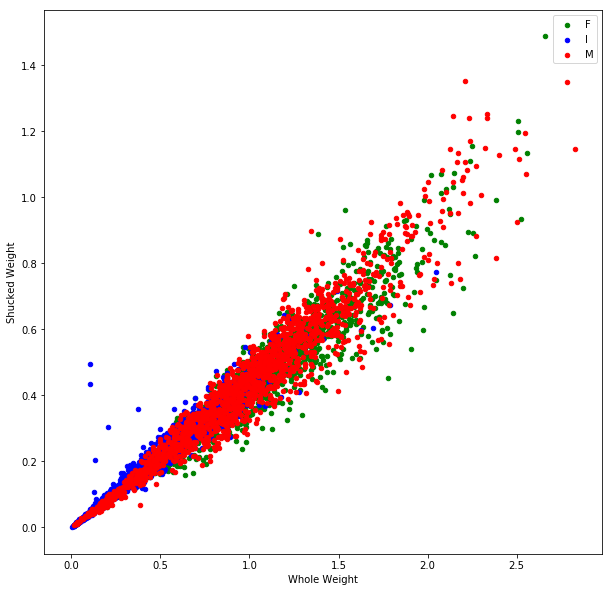

In [13]:
whole_vs_shucked = df[['Sex', 'Whole Weight', 'Shucked Weight']]
colors = {'M': 'red','F':'green', 'I': 'blue'}

_, ax = plt.subplots()
for key,group in whole_vs_shucked.groupby('Sex'):
    group.plot.scatter(ax=ax, x='Whole Weight', y='Shucked Weight',  figsize=(10, 10), label=key, color = colors[key]);

In the bottom left it seems we have some infants whose shucked weight is greater than the whole weight. 
We can get the exact rows using the formula below

In [14]:
df[df['Shucked Weight'] > df['Whole Weight']]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
1216,I,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5
2627,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5
2641,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7
3086,I,0.355,0.270,0.075,0.2040,0.3045,0.0460,0.0595,7


Lets remove these rows

In [15]:
df.drop(df.index[[1216,2627,2641,3086]], inplace=True)

In [16]:
df.shape

(4168, 9)